#**Group 11 Final Project Part B** 

In this project's part we've been asked to classify positive and negative reviews on movies by implementing 2 different pre-trained models. We've chosen Bert and GPT2. 
Also, we've been asked to choose 2 different compression methods on 1 of the models -> so we've chosen bert's pruning and distillation.

In [1]:
!pip install transformers --q
!pip install sentencepiece --q
!pip install datasets --q
!pip install dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
import string
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from transformers import GPT2Config,GPT2Tokenizer,AdamW,GPT2ForSequenceClassification
from transformers import get_linear_schedule_with_warmup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#plot measures function
def plotting_results(train_loss,train_acc,val_loss,val_acc,epoch_num):
  fig, axs = plt.subplots(2, 2, figsize=(10,10))
  axs[0, 0].plot(epoch_num, train_loss)
  axs[0, 0].set_title("Train Loss")
  axs[1, 0].plot(epoch_num, train_acc)
  axs[1, 0].set_title("Train Accuracy")
  axs[0, 1].plot(epoch_num, val_loss,color="r")
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(epoch_num, val_acc,color="r")
  axs[1, 1].set_title("Test Accuracy")
  return fig.tight_layout()

In [5]:
# Dataset creator class for pytorch
class Create_Data(Dataset):
    def __init__(self, data_proc, train):
        self.data = data_proc
        self.train = train
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        line = self.data.iloc[index]
        return {'text': line['text'], 'label': line['lable']}

# Defining the Class for tokenization and processing the text for input to the data_loader    
class Coll_General(nn.Module):
    def __init__(self, tokenizer, max_seq_len=None,model=None):
        super(Coll_General, self).__init__()
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.model=model
        return
    
    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [int(sequence['label']) for sequence in sequences]
        inputs = self.tokenizer(text=texts,
                                return_tensors='pt',
                                padding=True,
                                truncation=True,
                                max_length=self.max_seq_len)
        inputs.update({'labels': torch.tensor(labels)})       
        return inputs
    def unfreeze_layers(self,num_layer):
      for ind, x in enumerate(self.model.modules()):
          print(ind, '->', x)
          #Comparing to feature extractor, now we are gonna unfreeze part of the layers and train our model using them
          if ind > num_layer:
              for param in x.parameters():
                  param.requires_grad = True      

# Training function
def train(data_loader, optimizer, scheduler, device):
    global model
    model.train()
    predictions_labels = []
    true_labels = []
    total_loss = 0
    
    for batch in tqdm(data_loader, total=len(data_loader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(data_loader)
    return predictions_labels, true_labels, avg_epoch_loss

# Function for validation 
def validate(data_loader, device):
    global model
    model.eval()
    predictions_labels = []
    true_labels = []
    total_loss = 0
    
    for batch in tqdm(data_loader, total=len(data_loader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            total_loss += loss.item()
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(data_loader)
    return predictions_labels, true_labels, avg_epoch_loss


In [6]:
max_len = 128 # Max lenght of the text for input
batch_size = 16
epochs = 5
epoch_list = range(1, epochs+1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **GPT2**

In [7]:
dataset = pd.read_csv('/content/final_data_all_comments.csv')# read data
dataset=dataset[:4000]
copy_data = dataset.copy()

dataset = copy_data.sample(frac=0.80, random_state=0)
val_dataset = copy_data.drop(dataset.index)

,text,lable
2230,This film had some very funny moments. The afo...,1
668,Don't waste your time or money on going to see...,0
3616,It is not an easy film to watch - it is over t...,1
2363,I'd give this film a zero if I could. How anyo...,0
142,This is a pretty pointless remake. Starting wi...,0


In [8]:
torch.cuda.empty_cache()

defining the model and tokenizer

In [9]:
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path='gpt2', num_labels=2)
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path='gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path='gpt2', config=model_config)
model.resize_token_embeddings(len(tokenizer)) 
model.config.pad_token_id = model.config.eos_token_id
model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid

In [10]:
CollGpt2 = Coll_General(tokenizer=tokenizer, max_seq_len=max_len,model=model)
CollGpt2.unfreeze_layers(len(list(model.modules()))-8)
# Prepare training data
train_data = Create_Data(dataset, train=True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=CollGpt2)
# Prepare validation data

val_data = Create_Data(val_dataset, train=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=CollGpt2)

0 -> Coll_General()


In [11]:
import gc
torch.cuda.empty_cache()
gc.collect()

439

In [12]:
def train_model(train_dataloader,val_dataloader):
  optimizer = AdamW(model.parameters(), lr = 1e-5, eps = 1e-8, weight_decay=0.01)
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
  loss = []
  accuracy = []
  val_loss_list = []
  val_accuracy_list = []

  for epoch in tqdm(range(epochs)):
      train_labels, true_labels, train_loss = train(train_dataloader, optimizer, scheduler, device)    
      train_acc = accuracy_score(true_labels, train_labels) 
      print('epoch: %.2f train accuracy %.2f' % (epoch, train_acc))
      loss.append(train_loss)
      accuracy.append(train_acc)

      val_labels, val_true_labels, val_loss = validate(val_dataloader, device)
      val_acc= accuracy_score(val_true_labels, val_labels)
      print('epoch: %.2f validation accuracy %.2f' % (epoch, val_acc))
      val_loss_list.append(val_loss)
      val_accuracy_list.append(val_acc)
  return loss,accuracy,val_loss_list,val_accuracy_list



In [13]:
# Training the Model
gpt_loss,gpt_accuracy,gpt_val_loss_list,gpt_val_accuracy_list = train_model(train_dataloader,val_dataloader)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 200/200 [01:28<00:00,  2.25it/s]


epoch: 0.00 train accuracy 0.57



 20%|██        | 1/5 [01:37<06:29, 97.26s/it]

epoch: 0.00 validation accuracy 0.66



100%|██████████| 200/200 [01:29<00:00,  2.23it/s]


epoch: 1.00 train accuracy 0.74



 40%|████      | 2/5 [03:15<04:52, 97.60s/it]

epoch: 1.00 validation accuracy 0.74



100%|██████████| 200/200 [01:32<00:00,  2.17it/s]


epoch: 2.00 train accuracy 0.82



 60%|██████    | 3/5 [04:55<03:17, 98.97s/it]

epoch: 2.00 validation accuracy 0.78



100%|██████████| 200/200 [01:32<00:00,  2.15it/s]


epoch: 3.00 train accuracy 0.83



 80%|████████  | 4/5 [06:36<01:39, 99.85s/it]

epoch: 3.00 validation accuracy 0.77



100%|██████████| 200/200 [01:33<00:00,  2.15it/s]


epoch: 4.00 train accuracy 0.85



100%|██████████| 5/5 [08:18<00:00, 99.68s/it] 

epoch: 4.00 validation accuracy 0.80


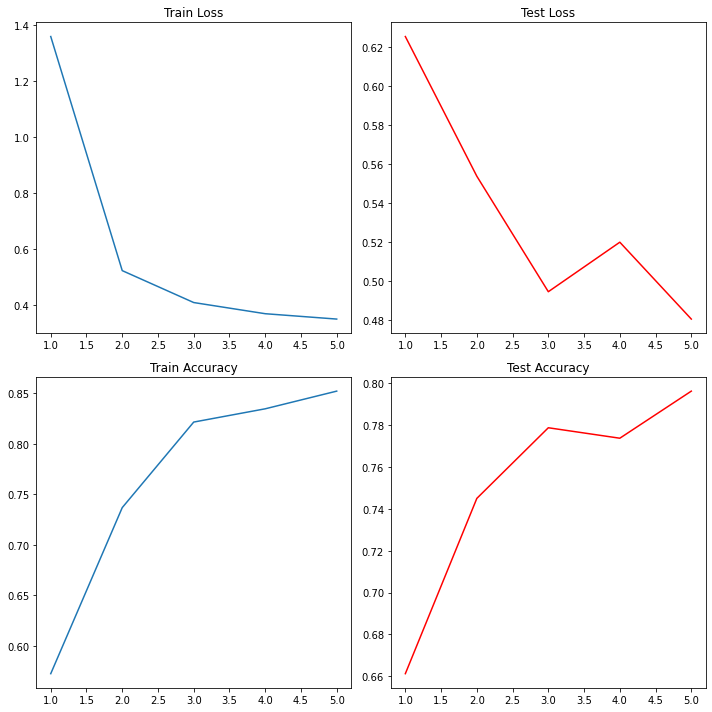

In [14]:
#Plotting the results
plotting_results(gpt_loss,gpt_accuracy,gpt_val_loss_list,gpt_val_accuracy_list,epoch_list)

# **BERT**

In [15]:
data = pd.read_csv('/content/final_data.csv') # read data
data=data[:4000]

,text,lable
0,its too bad that no one knows anything about t...,1
1,This film plays really well with an audience. ...,1
2,For the people who have compared this TRASH to...,0
3,The early films of the Dead End Kids (before t...,1
4,"THE IMMORTALIZER was, uh, interesting. It cert...",0


In [16]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')  # load tokenizer

In [17]:
df_train, df_test = train_test_split(data, test_size=0.15, random_state=42)      # split data
df_val, df_test = train_test_split(df_test, test_size=0.3, random_state=42)     # split data
df_train.shape, df_val.shape, df_test.shape


((3400, 2), (420, 2), (180, 2))

In [18]:
def tokenize_df(tokenizer, data, has_label=True):                             # tokenize data
        #convert to list
        tweet_list = data['text'].tolist()
        #returns dictionary with keys: input_ids, attention_mask)
        encoding_dict = tokenizer(tweet_list, padding="max_length", max_length=64,
                                  truncation=True, return_token_type_ids=False)
        #add 'label' key if we are making train or validation data
        if has_label: 
            encoding_dict['label'] = data['lable'].tolist()
        #convert dictionary of lists into list of dictionaries
        return [dict(zip(encoding_dict, t)) for t in zip(*encoding_dict.values())]

#apply above function to create lists to use for our data:
X_train_tokenized = tokenize_df(tokenizer_bert, df_train)
X_val_tokenized = tokenize_df(tokenizer_bert, df_val)

In [19]:
train_dataset = X_train_tokenized
eval_dataset = X_val_tokenized
test_dataset = X_test_tokenized

In [20]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)  # load model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # set device
model.to(device)
print(f'Using {device}')

Using cuda


In [22]:
torch.cuda.empty_cache()

## Define Training arguments

In [23]:
bert=Coll_General(tokenizer_bert,max_len,model=model)
#unfreeze layers for fine tuning
bert.unfreeze_layers(len(list(bert.modules()))-8)
# Prepare training data
train_data = Create_Data(dataset, train=True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=bert)

# Prepare validation data
val_data = Create_Data(val_dataset, train=True)
test_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=bert)

0 -> Coll_General()


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 200/200 [01:33<00:00,  2.13it/s]


epoch: 0.00 train accuracy 0.72



 20%|██        | 1/5 [01:44<06:57, 104.46s/it]

epoch: 0.00 validation accuracy 0.83



100%|██████████| 200/200 [01:35<00:00,  2.10it/s]


epoch: 1.00 train accuracy 0.87



 40%|████      | 2/5 [03:30<05:15, 105.32s/it]

epoch: 1.00 validation accuracy 0.84



100%|██████████| 200/200 [01:35<00:00,  2.10it/s]


epoch: 2.00 train accuracy 0.92



 60%|██████    | 3/5 [05:16<03:31, 105.60s/it]

epoch: 2.00 validation accuracy 0.85



100%|██████████| 200/200 [01:35<00:00,  2.10it/s]


epoch: 3.00 train accuracy 0.95



 80%|████████  | 4/5 [07:02<01:45, 105.79s/it]

epoch: 3.00 validation accuracy 0.85



100%|██████████| 200/200 [01:35<00:00,  2.10it/s]


epoch: 4.00 train accuracy 0.96



100%|██████████| 5/5 [08:48<00:00, 105.71s/it]


epoch: 4.00 validation accuracy 0.84


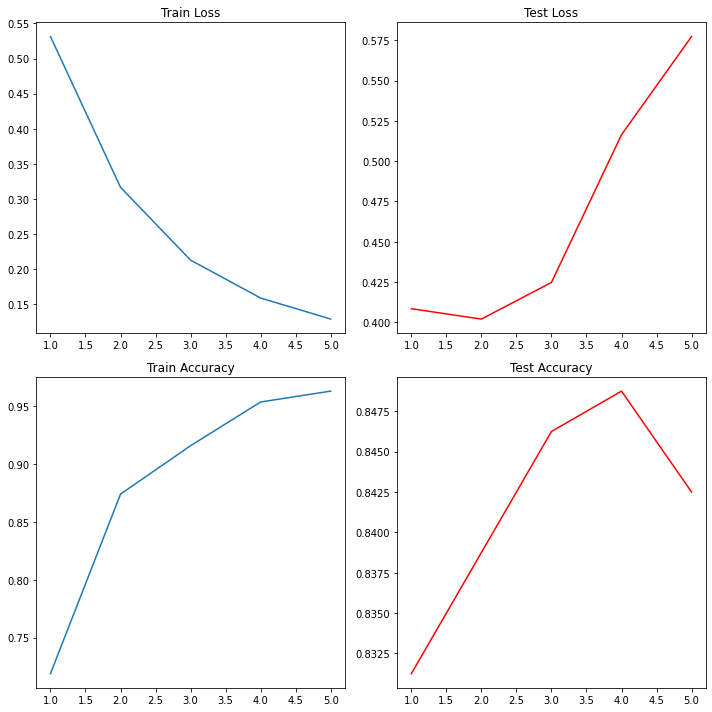

In [24]:
# Training the Model
bert_loss,bert_accuracy,bert_val_loss_list,bert_val_accuracy_list = train_model(train_dataloader,val_dataloader)

#Plotting the results
plotting_results(bert_loss,bert_accuracy,bert_val_loss_list,bert_val_accuracy_list,epoch_list)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)
output_model = '/content/bert_model.pt'

# save
def save(model, optimizer):                                                # save model
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

save(bert, optimizer)

# **Model Pruning - shrink method for BERT**

In [25]:
!pip install torch_pruning  # install torch_pruning
!pip install pytorch_pretrained_bert # install pytorch_pretrained_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 35.3 MB/s 
     |████████████████████████████████| 132 kB 59.8 MB/s 
     |████████████████████████████████| 8.9 MB 57.7 MB/s 
     |████████████████████████████████| 79 kB 7.7 MB/s 


In [26]:
import torch_pruning as tp
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

## Build the model from Module class

In [27]:
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)
print ('done')

done


## Inspecting the Module

In [28]:
#A function which performs the pruning
def our_pruning(model,size):
  inst=nn.modules.linear.Linear
  layers_to_prune=[]
  for module in model.modules():
    if isinstance(module, inst):
      layers_to_prune.append((module,'weight'))
  prune.global_unstructured(
          parameters=layers_to_prune, pruning_method=prune.L1Unstructured,
          amount=size)
  for module, _ in layers_to_prune:
    prune.remove(module, 'weight')
  return model


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 200/200 [01:39<00:00,  2.00it/s]


epoch: 0.00 train accuracy 0.95



 20%|██        | 1/5 [01:50<07:22, 110.53s/it]

epoch: 0.00 validation accuracy 0.85



100%|██████████| 200/200 [01:36<00:00,  2.08it/s]


epoch: 1.00 train accuracy 0.98



 40%|████      | 2/5 [03:37<05:25, 108.39s/it]

epoch: 1.00 validation accuracy 0.83



100%|██████████| 200/200 [01:35<00:00,  2.10it/s]


epoch: 2.00 train accuracy 0.99



 60%|██████    | 3/5 [05:23<03:34, 107.31s/it]

epoch: 2.00 validation accuracy 0.85



100%|██████████| 200/200 [01:38<00:00,  2.03it/s]


epoch: 3.00 train accuracy 0.99



 80%|████████  | 4/5 [07:13<01:48, 108.41s/it]

epoch: 3.00 validation accuracy 0.85



100%|██████████| 200/200 [01:35<00:00,  2.09it/s]


epoch: 4.00 train accuracy 0.99



100%|██████████| 5/5 [08:59<00:00, 107.98s/it]


epoch: 4.00 validation accuracy 0.84
Pruning 10.0 %  of the model parameters results


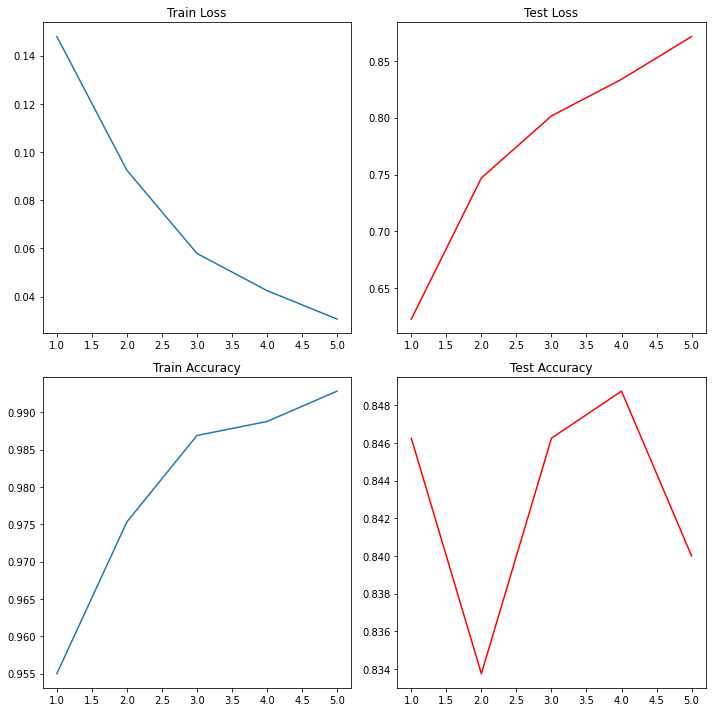

In [29]:
#pruning 10%
sizes=np.arange(0.1,0.3,0.1)
pruned_model=our_pruning(model,sizes[0])
pruned_model_10=Coll_General(tokenizer=tokenizer_bert, max_seq_len=max_len)
data_proc = preprocess(dataset)
train_data = Create_Data(data_proc, train=True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pruned_model_10)

# Prepare validation data
val_data = Create_Data(val_dataset, train=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=pruned_model_10)
# Training the Model
bert_loss,bert_accuracy,bert_val_loss_list,bert_val_accuracy_list = train_model(train_dataloader,val_dataloader)

#############################################
print (fr'Pruning {sizes[0]*100} %  of the model parameters results')
plotting_results(bert_loss,bert_accuracy,bert_val_loss_list,bert_val_accuracy_list,epoch_list)


In [ ]:
optimizer = torch.optim.AdamW(pruned_model.parameters(), lr=1e-5, weight_decay=1e-2)
output_model = '/content/trained_pruning_20%.pth'

# save
def save(pruned_model, optimizer):                                                # save model
    # save
    torch.save({
        'model_state_dict': pruned_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

save(pruned_model, optimizer)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 200/200 [01:35<00:00,  2.10it/s]


epoch: 0.00 train accuracy 0.99



 20%|██        | 1/5 [01:45<07:03, 105.90s/it]

epoch: 0.00 validation accuracy 0.86



100%|██████████| 200/200 [01:35<00:00,  2.10it/s]


epoch: 1.00 train accuracy 0.99



 40%|████      | 2/5 [03:31<05:17, 105.93s/it]

epoch: 1.00 validation accuracy 0.83



100%|██████████| 200/200 [01:35<00:00,  2.09it/s]


epoch: 2.00 train accuracy 0.99



 60%|██████    | 3/5 [05:18<03:32, 106.05s/it]

epoch: 2.00 validation accuracy 0.85



100%|██████████| 200/200 [01:38<00:00,  2.03it/s]


epoch: 3.00 train accuracy 1.00



 80%|████████  | 4/5 [07:07<01:47, 107.24s/it]

epoch: 3.00 validation accuracy 0.84



100%|██████████| 200/200 [01:36<00:00,  2.08it/s]


epoch: 4.00 train accuracy 1.00



100%|██████████| 5/5 [08:54<00:00, 106.82s/it]


epoch: 4.00 validation accuracy 0.85
Pruning 20.0 %  of the model parameters results


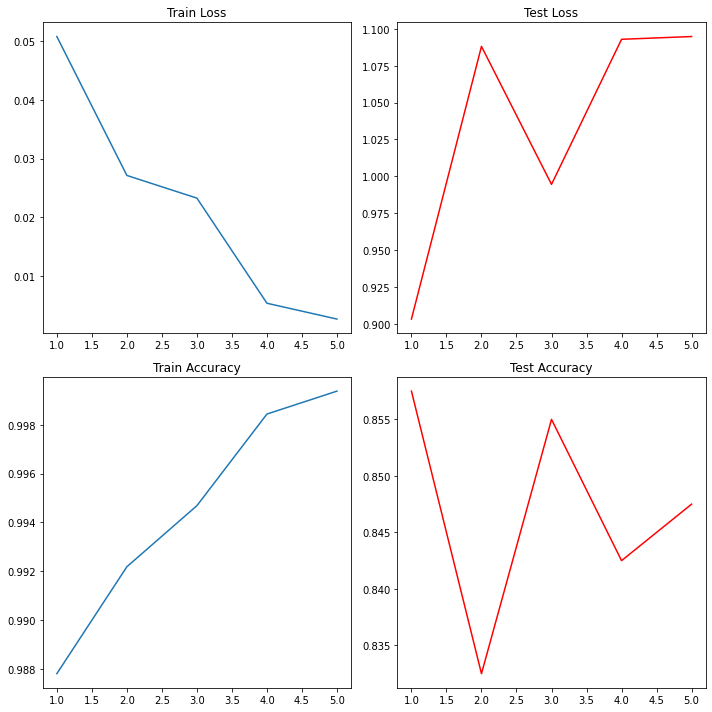

In [30]:
#pruning 20%
pruned_model=our_pruning(model,sizes[1])
pruned_model_20=Coll_General(tokenizer=tokenizer_bert, max_seq_len=max_len)
train_data = Create_Data(dataset, train=True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pruned_model_20)

# Prepare validation data
val_data = Create_Data(val_dataset, train=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=pruned_model_20)
# Training the Model
bert_loss,bert_accuracy,bert_val_loss_list,bert_val_accuracy_list = train_model(train_dataloader,val_dataloader)

#Plotting the results
print (fr'Pruning {sizes[1]*100} %  of the model parameters results')
plotting_results(bert_loss,bert_accuracy,bert_val_loss_list,bert_val_accuracy_list,epoch_list)

## Save the Model

In [32]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
output_model = '/trained_bert.pth'

# save
def save(model, optimizer):                                                # save model
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

save(model, optimizer)

# **Distillation - shrink method for BERT**

In [75]:
!pip install transformers --q #4.8.2
!pip install datasets --q
!pip install textbrewer --q
from transformers import AutoTokenizer, AutoModel

In [76]:
df = pd.read_csv('/content/final_data.csv') # read data
df=df[:2000]
df['label'] = df['lable']
df.drop(columns=['lable'], inplace= True)
batch_size=8

In [77]:
torch.cuda.empty_cache()

In [78]:
labels = df['label'].tolist()
data=df['text'].tolist()

In [79]:
train_labels = labels[:int(0.8*len(df))]
test_labels = labels[int(0.8*len(df)):]

In [80]:
train_data=data[:int(0.8*len(df))]
test_data=data[int(0.8*len(df)):]

In [81]:
# Dataset creator class for pytorch
class DistData(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
      X = self.data[index]
      y = self.label[index]
      return X, y

In [82]:
train_dataset = DistData(train_data, train_labels)
test_dataset = DistData(test_data, test_labels)

In [83]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)

In [84]:
teacher_model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)  # load pretrained model
teacher_tokenizer_distillation = BertTokenizer.from_pretrained('bert-base-uncased') # load pretrained tokenizer

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [85]:
from transformers import pipeline
student_model= BertForSequenceClassification.from_pretrained('nlpaueb/legal-bert-small-uncased',num_labels=2)  # load pretrained model
student_tokenizer_distillation=AutoTokenizer.from_pretrained("nlpaueb/legal-bert-small-uncased")

Some weights of the model checkpoint at nlpaueb/legal-bert-small-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

We save the original model and tweak the parameters to simplify the student model configuration by reducing the number of layers

Tokenizing the data set and set the model input formats

Accuracy metrics

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher_model.to(device)
student_model.to(device)
print ('done')

done


In [87]:
def tokenizing_bert(X,y, tokenizer) :
  if tokenizer==student_tokenizer_distillation:
    X=list(X)
  inputs =  tokenizer(X, max_length = 128, padding = 'max_length', truncation = True, return_tensors="pt")
  input_ids = inputs.input_ids.to(device)
  attention_mask = inputs.attention_mask.to(device) 
  token_type_ids = inputs['token_type_ids'].to(device)
  labels=torch.tensor(y)
  labels = labels.to(device)

  return input_ids,token_type_ids, attention_mask, labels

In [88]:
# Accuracy calculation
def calc_metric(target, pred,metric):
    pred=[p.cpu().numpy() for p in pred]
    target=[t.cpu().numpy() for t in target]
    batch_metric_score = accuracy_score(target, pred)
    return batch_metric_score
#create the label of prediction by argmax

Training

In [90]:
#Train and evaluation loop
def Train_KBD(teacher_model, student_model, teacher_tokenizer, student_tokenizer, loss_function, alpha, optim, epochs, train_dataloader, test_dataloader, tb_dirname):
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list=[]
    test_accuracy_list = []

    for epoch in range(epochs):
        running_loss = 0
        train_accuracy = 0
        student_model.train()
        train_loop=train_dataloader
        
        for X, y in tqdm(train_loop):
            optim.zero_grad()
            # Tokenize input for the teacher model
            teacher_ids,teacher_token_type_ids, teacher_mask, teacher_labels = tokenizing_bert(X, y, teacher_tokenizer)
            # predicition
            teacher_outputs = teacher_model(input_ids=teacher_ids,
                                    token_type_ids=teacher_token_type_ids,
                                    attention_mask=teacher_mask,
                                    labels=teacher_labels)
            #Extract the logits vector
            teacher_logits = teacher_outputs.logits
            
            # Tokenize input for the student model (Bert-small)
            student_ids,student_token_type_ids, student_mask, student_labels = tokenizing_bert(X, y, student_tokenizer)
            # prediction
            student_outputs = student_model(input_ids=student_ids,
                                    token_type_ids=student_token_type_ids,
                                    attention_mask=student_mask,
                                    labels=student_labels)
            # Extract to logits vector
            student_logits = student_outputs.logits
            # Calculate the MSE loss betweem the teacher and the student logits
            loss_teacher = loss_function(student_logits, teacher_logits)
            # Cacluate the loss of the student model compare to the ground truth label
            loss_ground_truth = student_outputs.loss
            # Calculate the final loss as weighted average of the two losses
            loss = alpha * loss_teacher + (1-alpha) * loss_ground_truth
            student_labels_train=torch.argmax(student_logits, dim =1)
            batch_accuracy = calc_metric(y, student_labels_train, 'accuracy')
            train_accuracy+=batch_accuracy
            loss.backward()
            optim.step()
            running_loss+=loss.item()

        
        epoch_train_loss = running_loss/len(train_dataloader.dataset)
        epoch_train_accuracy=train_accuracy/len(train_dataloader)
        train_loss_list.append(epoch_train_loss)
        train_accuracy_list.append(epoch_train_accuracy)

        test_loss = 0
        test_accuracy = 0
        teacher_model.eval()
        total_eval_loss=0
        with torch.no_grad():
            eval_loop = tqdm(test_dataloader)
            for X_test, y_test in eval_loop:
                ids,token_type_ids, mask, labels = tokenizing_bert(X_test, y_test, student_tokenizer)
                outputs = student_model( input_ids=ids,
                                                token_type_ids=token_type_ids,
                                                attention_mask=mask,
                                              labels=student_labels)
                y_pred =torch.argmax(outputs.logits, dim =1)
  
                batch_accuracy = calc_metric(labels, y_pred, 'accuracy')
                batch_test_loss = loss.item()
                test_loss+=batch_test_loss
                test_accuracy+=batch_accuracy
                
        epoch_accuracy = test_accuracy/len(test_dataloader)
        test_accuracy_list.append(epoch_accuracy)
        epoch_test_loss = test_loss/len(test_dataloader.dataset)
        test_loss_list.append(epoch_test_loss)
    
    trained_model_params_path = '/content/student_model_trained_params.pt'
    torch.save({
            'model_state_dict': student_model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            }, trained_model_params_path)
       
    return {
            'train_loss':train_loss_list,
            'test_loss':test_loss_list,
            'train_accuracy':train_accuracy_list,
            'test_accuracy':test_accuracy_list,

            }

In [91]:
#Enter model to device
#Define optimizer
optim = torch.optim.AdamW(student_model.parameters(), lr = 1e-5)
#Apply get data function
bert_small_trained_results = Train_KBD( teacher_model=teacher_model,
                                                            student_model=student_model,
                                                            loss_function=torch.nn.MSELoss(),
                                                            alpha = 0.5,
                                                            optim = optim,
                                                            epochs= 13,
                                                            teacher_tokenizer= teacher_tokenizer_distillation,
                                                            student_tokenizer= student_tokenizer_distillation, 
                                                            train_dataloader = train_dataloader,
                                                            test_dataloader=test_dataloader,
                                                            tb_dirname ='knowledgeDistilation')


Streaming output truncated to the last 5000 lines.
  del sys.path[0]
  6%|▌         | 11/200 [00:03<00:56,  3.33it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
  6%|▌         | 12/200 [00:03<00:57,  3.28it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
  6%|▋         | 13/200 [00:03<00:55,  3.36it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather t

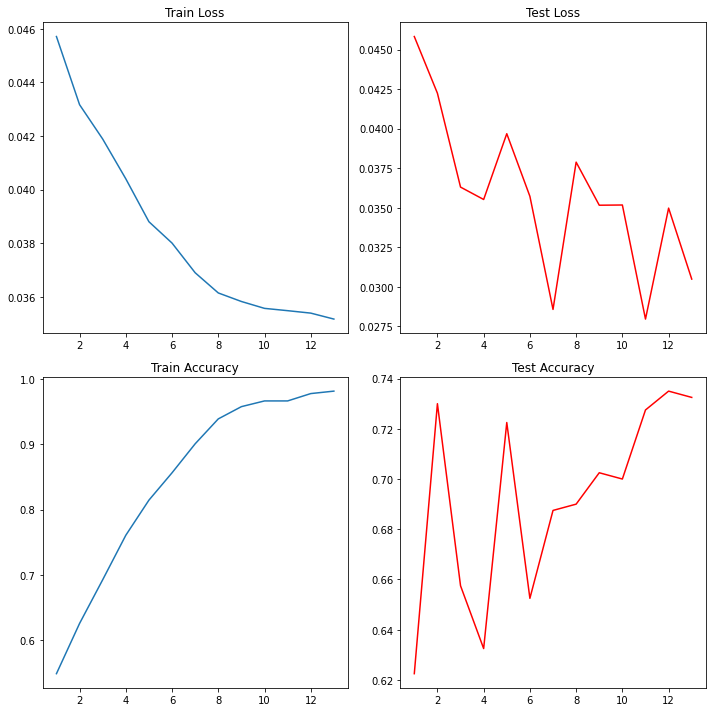

In [92]:
plotting_results(train_loss=bert_small_trained_results['train_loss'],train_acc=bert_small_trained_results['train_accuracy'],val_loss=bert_small_trained_results['test_loss'],val_acc=bert_small_trained_results['test_accuracy'],epoch_num=[i for i in range(1,14)])

In [93]:
torch.save(model.state_dict(), './trained_model_distillation.pt')